In [1]:
from models import *
from utilities import *
from functools import partial
import matplotlib.pyplot as plt

print('Working directory:', os.getcwd())


Working directory: /Users/briel/data/glaciers/modeling/ice_shelf_icepack/with_ice_rises/variational-with-icepack/new_2022-07-19


In [2]:
def _gradient(Z, spacing):
    dy, dx = spacing
    return np.gradient(Z, dy, axis=0), np.gradient(Z, dx, axis=1)

def force_balance_ssa(U, V, H, B, n, spacing):
    """
    Compute stresses at bed of glacier.
    """
    dy, dx = spacing
    u_y, u_x = _gradient(U, spacing)
    v_y, v_x = _gradient(V, spacing)
    h_y, h_x = _gradient(H, spacing)
    h = H

    # Compute driving stress components
    rho_ice = 917.0
    rho_water = 1024.0
    g = 9.80665
    s_x = h_x * (1 - rho_ice / rho_water)
    s_y = h_y * (1 - rho_ice / rho_water)
    tdx = -1.0e-3 * rho_ice * g * H * s_x
    tdy = -1.0e-3 * rho_ice * g * H * s_y

    # Compute viscosity
    strain = np.sqrt(u_x**2 + v_y**2 + u_x * v_y + 0.25 * (u_y + v_x)**2) + 1.0e-5
    eta = 0.5 * B * strain**((1.0 - n) / n)

    # Membrane stresses in X-direction
    argx = 2.0 * eta * h * (2.0 * u_x + v_y)
    argy = eta * h * (u_y + v_x)
    tmxx = np.gradient(argx, dx, axis=1)
    tmxy = np.gradient(argy, dy, axis=0)
    tmx = tmxx + tmxy

    # Membrane stresses in Y-direction
    argy = 2.0 * eta * h * (2.0 * v_y + u_x)
    argx = eta * h * (u_y + v_x)
    tmyy = np.gradient(argy, dy, axis=0)
    tmyx = np.gradient(argx, dx, axis=1)
    tmy = tmyy + tmyx

    # Drag
    tbx = tmx + tdx
    tby = tmy + tdy
    drag = np.sqrt(tbx**2 + tby**2)

    return tbx, tby, drag


def print_gp_summary(gp):
    print('Variable values for', gp.name)
    print(' - amplitude:', gp.amplitude.numpy())
    print(' - length scale:', gp.length_scale.numpy())
    print(' - noise variance:', gp.noise_variance.numpy())
    print('')

In [3]:
# Parameters
pars = ParameterClass('run.cfg')

# Load normalizers
norms = make_normalizers()

# Reference x, normalized
with h5py.File(H5FILE, 'r') as fid:
    x_ref = norms['x'](fid['x'][()])
    y_ref = norms['y'](fid['y'][()])

# Make models
mean_net = MeanNetwork(norms, resnet=True)
vgp = create_vgp(x_ref, y_ref, pars.prior.num_inducing_x, pars.prior.num_inducing_y, norms)

# The grids to predict on
X, Y, U, V, H, B0, B_ref, mask = [h5read('data_grids.h5', key) for key in
                                  ('X', 'Y', 'U', 'V', 'H', 'B', 'B_ref', 'mask')]
spacing = (Y[1,0] - Y[0,0], X[0,1] - X[0,0])

# Valid mask (make sure to use even number of points)
mask1d = mask.ravel().nonzero()[0]
nanmask1d = np.invert(mask.ravel())

# Points to predict
X_pts = X.ravel()[mask1d]
Y_pts = Y.ravel()[mask1d]
print('Number of prediction points:', X_pts.size)

# Mask obs grids
for arr in (U, V, H, B0):
    arr.ravel()[nanmask1d] = np.nan

Number of prediction points: 237550


In [4]:
# Create checkpoint manager
CHECKDIR = pars.train.checkdir

print('Restoring from', CHECKDIR)
ckpt_manager = create_checkpoint_manager(
    CHECKDIR,
    mean_net=mean_net,
    vgp=vgp,
    restore=True
)

# Predict
values = mean_net(X_pts.reshape(-1, 1), Y_pts.reshape(-1, 1), inverse_norm=True)
Up, Vp, Hp, B0p = [v.numpy() for v in values]

Restoring from checkpoints/checkpoints_jointA


In [5]:
@tf.function
def _predict(xb, yb):
    """
    Function for predicting rheology.
    """
    # Normalized index points
    X = tf.concat(values=[xb, yb], axis=1)
    Xn = normalize_tensor(X, mean_net.iW_in, mean_net.b_in)

    # Predict rheology mean and stddev
    θ_mean = vgp.mean(index_points=Xn)
    θ_std = vgp.stddev(index_points=Xn)

    return θ_mean, θ_std

# Predict rheology on batches
batch_size = 1000
n_batches = int(np.ceil(X_pts.size / batch_size))
θp = np.zeros_like(X_pts)
θp_std = np.zeros_like(X_pts)
for b in tqdm(range(n_batches)):

    # Get batch of coordinates
    bslice = slice(b * batch_size, (b + 1) * batch_size)

    # Predict means
    values = _predict(X_pts[bslice].reshape(-1, 1), Y_pts[bslice].reshape(-1, 1))
    θ_mean, θ_std = [t.numpy().squeeze() for t in values]
    θp[bslice] = θ_mean
    θp_std[bslice] = θ_std

# Make 2D
def _make2d(arr):
    if isinstance(arr, tf.Tensor):
        arr = arr.numpy()
    print(arr.shape)
    out = np.full(X.shape, np.nan, dtype=np.float64)
    out.ravel()[mask1d] = arr.ravel()
    return out
Up, Vp, Hp, B0p, θp, θp_std = [
    _make2d(arr) for arr in
    (Up, Vp, Hp, B0p, θp, θp_std)
]

# Predict B
Bp = B0p * np.exp(θp)
Bp_std = Bp * θp_std

100%|██████████████████████████████████████████████████████████████| 238/238 [00:13<00:00, 18.00it/s]

(237550, 1)
(237550, 1)
(237550, 1)
(237550, 1)
(237550,)
(237550,)


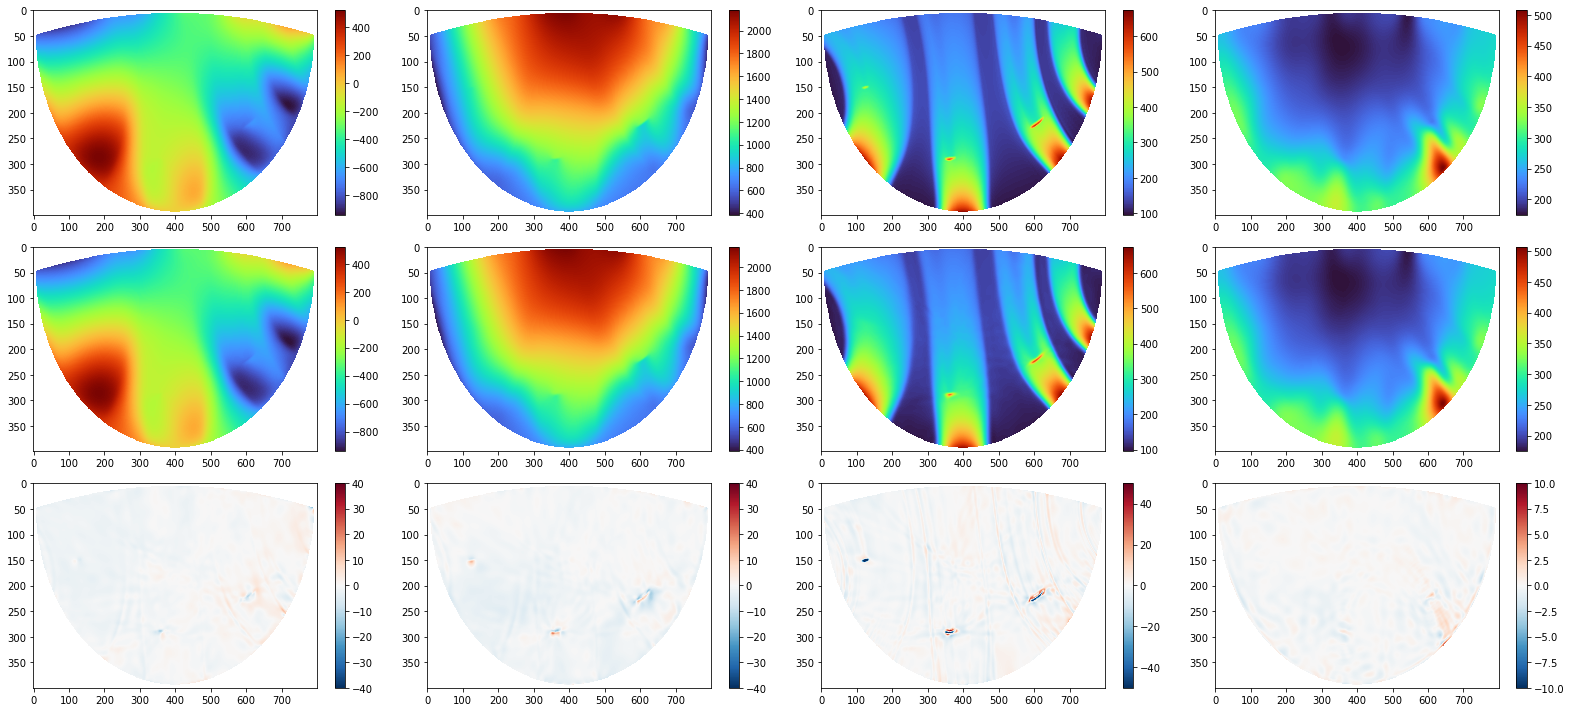

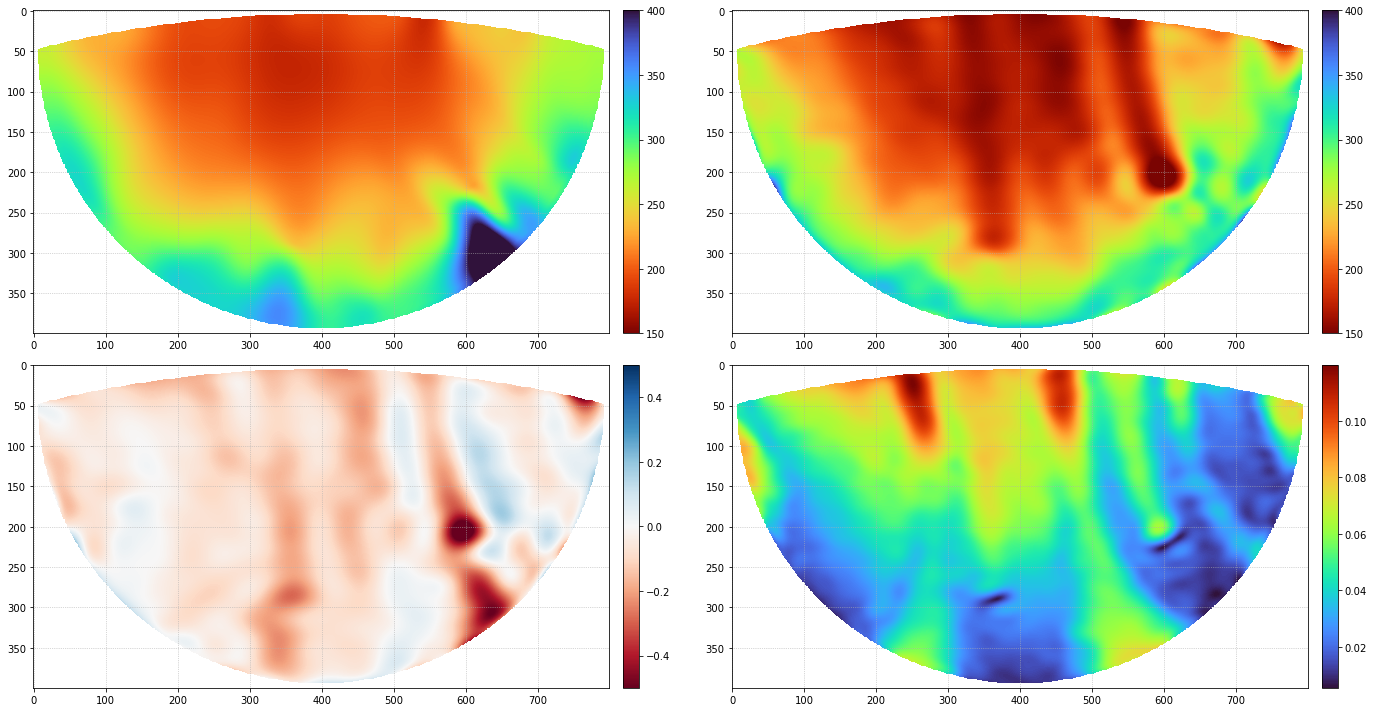

In [6]:
# Write predictions
with h5py.File('output_rasters.h5', 'w') as fid:
    fid['X'] = X
    fid['Y'] = Y
    fid['U'] = Up
    fid['V'] = Vp
    fid['H'] = Hp
    fid['B_mean'] = Bp
    fid['B_std'] = Bp_std
    fid['theta_mean'] = θp
    fid['theta_std'] = θp_std
    fid['B0'] = B0p

# View
fig, axes = plt.subplots(figsize=(22, 10), nrows=3, ncols=4)

def _imshow(i, j, arr, ref, cmap='turbo', ref_clim=None, sync_clim=True, diff_clim=None):
    ax1 = axes[i, j]
    ax2 = axes[i+1, j]
    ax3 = axes[i+2, j]
    im1 = ax1.imshow(ref, aspect='auto', cmap=cmap, clim=ref_clim)
    im2 = ax2.imshow(arr, aspect='auto', cmap=cmap)
    if sync_clim:
        im2.set_clim(im1.get_clim())
    im3 = ax3.imshow(arr - ref, aspect='auto', cmap='RdBu_r', clim=diff_clim)
    for im, ax in zip((im1, im2, im3), (ax1, ax2, ax3)):
        plt.colorbar(im, ax=ax)
    return im1, im2, im3

_imshow(0, 0, Up, U, diff_clim=(-40, 40))
_imshow(0, 1, Vp, V, diff_clim=(-40, 40))
_imshow(0, 2, Hp, H, diff_clim=(-50, 50))
_imshow(0, 3, B0p, B0, diff_clim=(-10, 10))

fig.set_tight_layout(True)

plt.show()

# View
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

def _imshow(i, j, arr, cmap='turbo_r', clim=None):
    ax = axes[i, j]
    im = ax.imshow(arr, aspect='auto', cmap=cmap, clim=clim)
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    ax.grid(True, ls=':', lw=0.7)
    return im, cbar

i1, c1 = _imshow(0, 0, B0, clim=(150, 400))
i2, c2 = _imshow(0, 1, Bp, clim=None)#i1.get_clim())
i2.set_clim(i1.get_clim())
#i1.set_clim(i2.get_clim())
#i3, c3 = _imshow(1, 0, Bp - B_ref, cmap='RdBu_r', clim=(-20, 20))
i3, c3 = _imshow(1, 0, θp, cmap='RdBu', clim=(-0.5, 0.5))
i4, c4 = _imshow(1, 1, θp_std, cmap='turbo', clim=None)

fig.set_tight_layout(True)
plt.show()

0.004467739792617091
0.30585123112826523


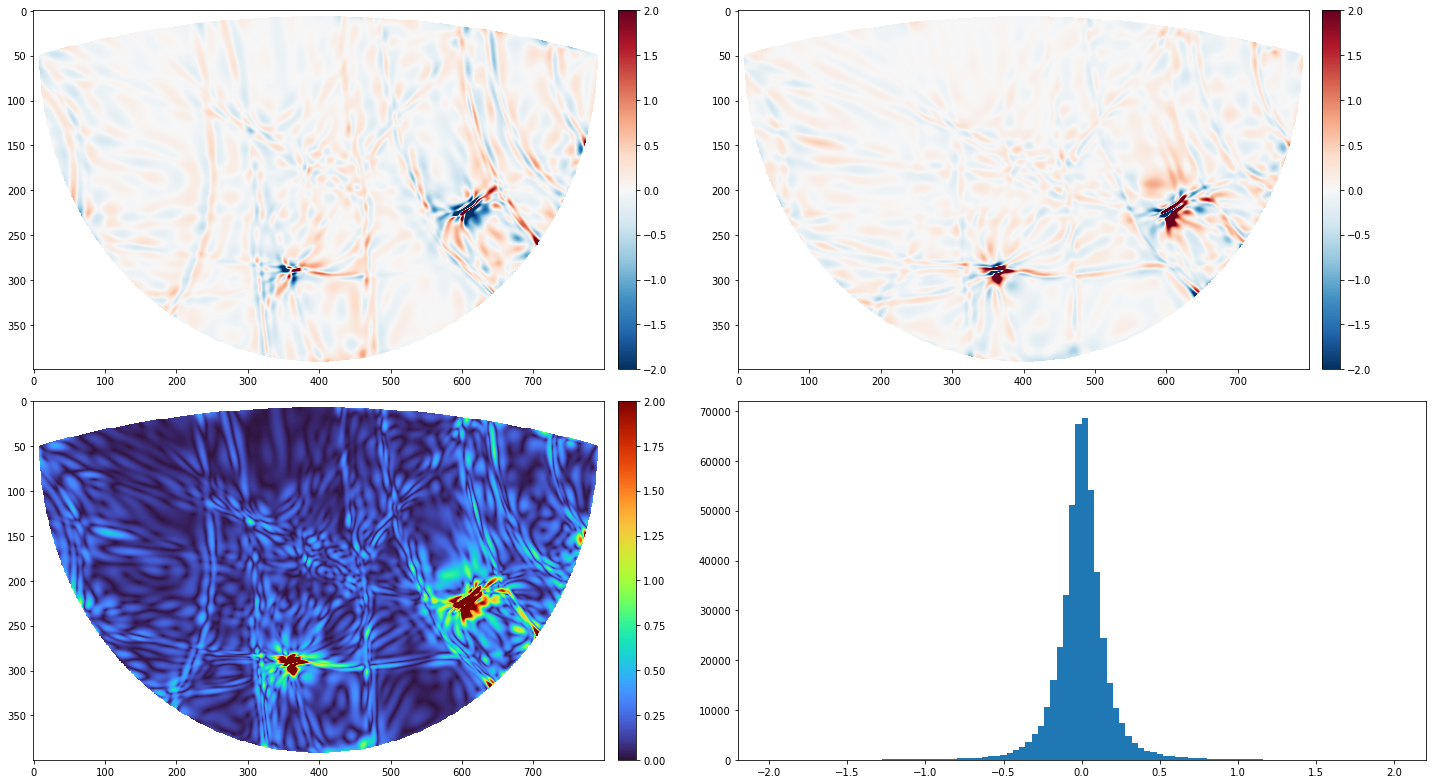

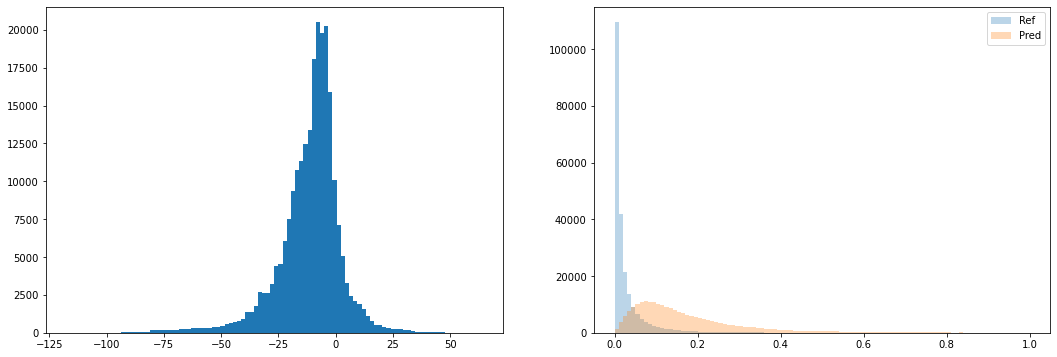

In [7]:
# Compute predicted drag
tbx_ref, tby_ref, Tb_ref = force_balance_ssa(U, V, H, B_ref, 4.0, spacing)
tbx, tby, Tb = force_balance_ssa(Up, Vp, Hp, Bp, 4.0, spacing)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 11))
axes = axes.ravel()

im0 = axes[0].imshow(tbx, aspect='auto', cmap='RdBu_r', clim=(-2, 2))
im1 = axes[1].imshow(tby, aspect='auto', cmap='RdBu_r', clim=(-2, 2))
im2 = axes[2].imshow(Tb, aspect='auto', cmap='turbo', clim=(0, 2))
for cnt, im in enumerate((im0, im1, im2)):
    plt.colorbar(im, ax=axes[cnt], pad=0.02)

mask = np.isfinite(tbx)
tb_stack = np.hstack((tbx[mask], tby[mask]))
print(np.mean(tb_stack))
print(np.std(tb_stack))
axes[3].hist(tb_stack, 100, range=(-2, 2))

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
diffB = Bp - B_ref
mask = np.isfinite(diffB)
ax[0].hist(diffB[mask], 100)
ax[1].hist(Tb_ref[mask], 100, alpha=0.3, label='Ref', range=(0, 1))
ax[1].hist(Tb[mask], 100, alpha=0.3, label='Pred', range=(0, 1))
ax[1].legend(loc='best')
plt.show()

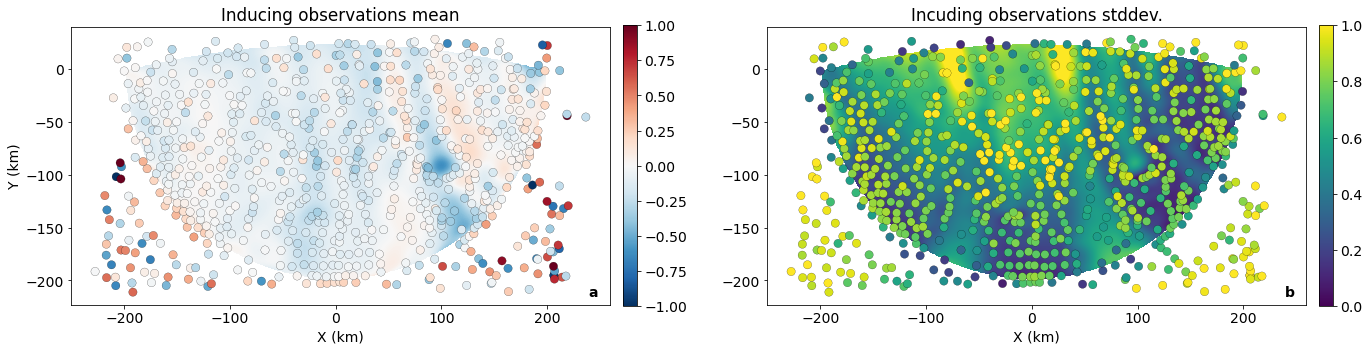

In [8]:
inducing_index_points = vgp.inducing_index_points.numpy()
inducing_loc = vgp.variational_inducing_observations_loc.numpy().squeeze()
inducing_scale = vgp.variational_inducing_observations_scale.numpy().squeeze()

#inducing_cov = np.dot(inducing_scale.T, inducing_scale)
#inducing_std = np.sqrt(np.diag(inducing_cov))
#inducing_std = np.diag(inducing_scale)

variational_inducing_observations_posterior = tfd.MultivariateNormalLinearOperator(
    loc=inducing_loc,
    scale=tf.linalg.LinearOperatorLowerTriangular(inducing_scale)
)
inducing_cov = variational_inducing_observations_posterior.covariance()
inducing_std = np.sqrt(np.diag(inducing_cov))

xi = norms['x'].inverse(inducing_index_points[:, 0])
yi = norms['y'].inverse(inducing_index_points[:, 1])

plt.rc('font', size=14)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

vmin = -1
vmax = 1
clim = (vmin, vmax)

extent = 1.0e-3 * np.array([X[0,0], X[0,-1], Y[-1,0], Y[0,0]])

im = ax1.imshow(θp, cmap='RdBu_r', clim=clim, extent=extent)
sc = ax1.scatter(1.0e-3*xi, 1.0e-3*yi, s=70, c=inducing_loc, cmap='RdBu_r',
                vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.2)
plt.colorbar(sc, ax=ax1, pad=0.02, shrink=0.7)

vmin = 0.0
vmax = 1.5
im = ax2.imshow(θp_std, cmap='viridis', clim=(0, 0.1), extent=extent)
sc = ax2.scatter(1.0e-3*xi, 1.0e-3*yi, s=70, c=inducing_std, cmap='viridis',
                 vmin=0.0, vmax=1.0, edgecolor='k', linewidth=0.2)
plt.colorbar(sc, ax=ax2, pad=0.02, shrink=0.7)

ax1.set_title('Inducing observations mean')
ax2.set_title('Incuding observations stddev.')

ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax2.set_xlabel('X (km)')

ax1.annotate('a', xy=(0.96, 0.03), xycoords='axes fraction',
             size=14, weight='semibold')
ax2.annotate('b', xy=(0.96, 0.03), xycoords='axes fraction',
             size=14, weight='semibold')

plt.tight_layout()
plt.savefig('figures/shelf2d_inducing_points.pdf', bbox_inches='tight')